# Using Computer Vision and Machine Learning to drive the Car

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json

#import ML liberaries
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Get the data from CSV file
data = pd.read_csv('data_output2024-01-03 20_51_53.508811.csv')

In [3]:
data.head()

,motion,timestamp,i,LMR,model_prediction,img
0,SlowForward,2024-01-03 20_51_23.078752,0,2,0,"[[86, 87, 91, 72, 89, 104, 107, 110, 117, 122,..."
1,SlowForward,2024-01-03 20_51_23.526859,1,2,0,"[[92, 96, 97, 83, 94, 99, 104, 109, 113, 119, ..."
2,SlowForward,2024-01-03 20_51_23.643797,2,2,0,"[[93, 96, 102, 86, 95, 98, 106, 111, 116, 122,..."
3,SlowForward,2024-01-03 20_51_23.773899,3,2,0,"[[86, 90, 94, 80, 90, 100, 106, 110, 113, 121,..."
4,SlowForward,2024-01-03 20_51_23.907948,4,2,0,"[[90, 92, 94, 79, 92, 99, 109, 112, 117, 119, ..."


In [4]:
len(data)

225

## 1. Visually Explore training data

In [7]:
# A function that takes the index and produce the image in that index in dataframe

def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['img'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()


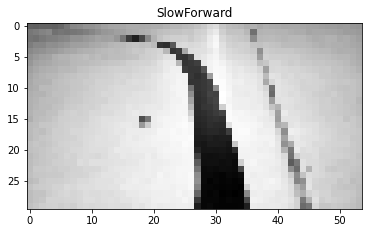

In [9]:
review_data (100)

In [10]:
    
def preview_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # number of histograms per raws & columns
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]} ") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

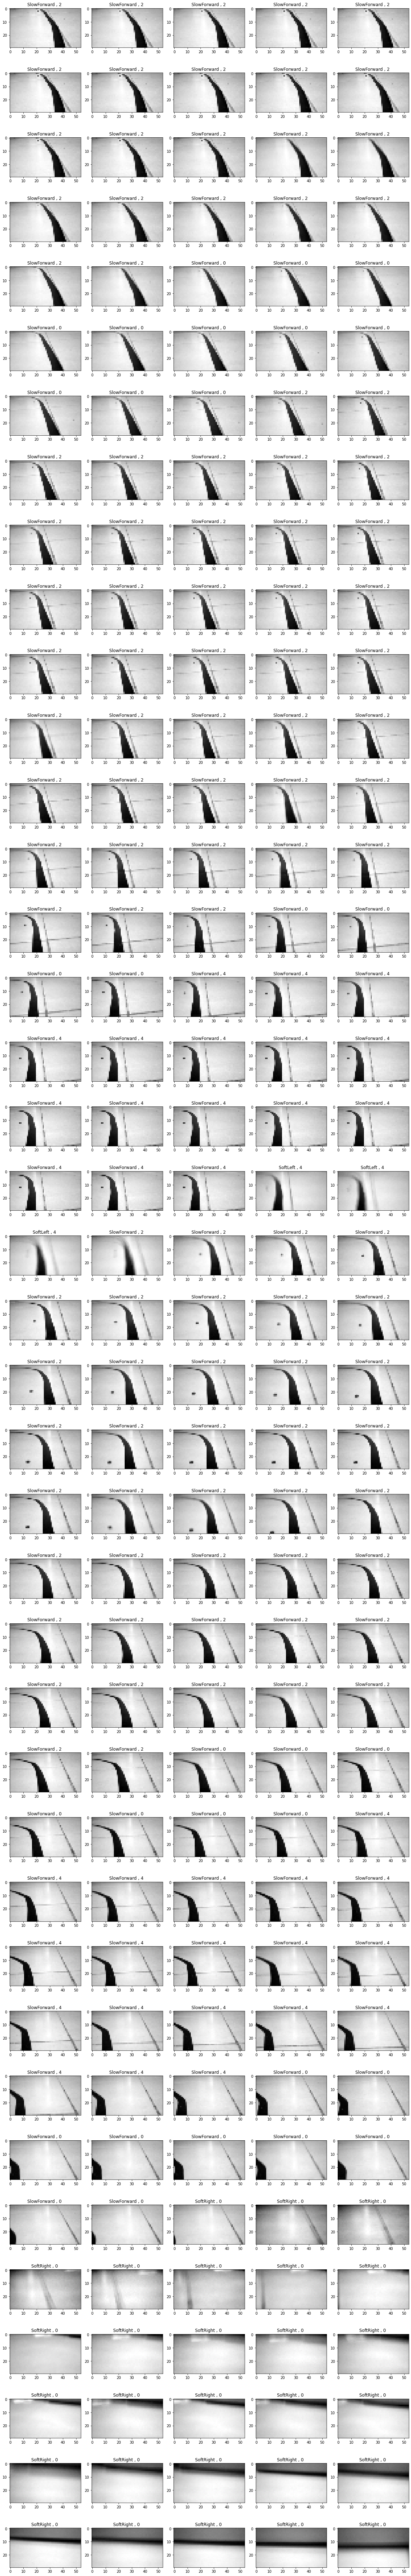

In [12]:
preview_dataset(data = data, 
                START_FRAME = 0, 
                END_FRAME = 200 )